In [5]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

print('tensorflow version', tf.__version__)

tensorflow version 2.11.0


In [277]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(24, 16))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')
    
    fig.tight_layout(pad=0.5)

    plt.show()

In [11]:
# import data
bank_data = pd.read_csv("fin_merged_data.csv")
bank_data.head()

,cik,fyear,company_name,tic,status_label,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,...,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,status,GOING_CONCERN,OPINION_TEXT1
0,1750,1999.0,AAR CORP,AIR,alive,511.267,740.998,833.107,180.447,18.373,...,201.026,128.348,1024.333,372.7519,401.483,1024.333,935.302,0,0.0,0
1,1750,2000.0,AAR CORP,AIR,alive,485.856,701.854,713.811,179.987,18.577,...,204.065,115.187,874.255,377.1180,361.642,874.255,809.888,0,0.0,0
2,1750,2001.0,AAR CORP,AIR,alive,436.656,710.199,526.477,217.699,22.496,...,139.603,77.528,638.721,364.5928,399.964,638.721,611.514,0,0.0,0
3,1750,2002.0,AAR CORP,AIR,alive,396.412,686.621,496.747,164.658,27.172,...,124.106,66.322,606.337,143.3295,391.633,606.337,575.592,0,0.0,0
4,1750,2003.0,AAR CORP,AIR,alive,432.204,709.292,523.302,248.666,26.680,...,131.884,104.661,651.958,308.9071,407.608,651.958,604.467,0,0.0,0


## Remove non-numerical

In [14]:
numerical_only = bank_data.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik','fyear','status'], axis=1)
y = numerical_only['status']
X.head()

,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,inventory,total_current_liabilities,net_income,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,GOING_CONCERN
0,511.267,740.998,833.107,180.447,18.373,70.658,89.031,191.226,336.018,163.816,35.163,201.026,128.348,1024.333,372.7519,401.483,1024.333,935.302,0.0
1,485.856,701.854,713.811,179.987,18.577,45.790,64.367,160.444,320.590,125.392,18.531,204.065,115.187,874.255,377.1180,361.642,874.255,809.888,0.0
2,436.656,710.199,526.477,217.699,22.496,4.711,27.207,112.244,286.588,150.464,-58.939,139.603,77.528,638.721,364.5928,399.964,638.721,611.514,0.0
3,396.412,686.621,496.747,164.658,27.172,3.573,30.745,109.590,259.954,203.575,-12.410,124.106,66.322,606.337,143.3295,391.633,606.337,575.592,0.0
4,432.204,709.292,523.302,248.666,26.680,20.811,47.491,128.656,247.245,131.261,3.504,131.884,104.661,651.958,308.9071,407.608,651.958,604.467,0.0


In [15]:
pos_samples = X[y == 1]
neg_samples = X[y == 0]

In [16]:
going = X[bank_data['GOING_CONCERN'] == 0.0]
not_going = X[bank_data['GOING_CONCERN'] == 1.0]

print(len(going))
print(len(not_going))

37752
41302


In [ ]:
going.head()

In [ ]:
not_going.head()

# Balance Data

In [17]:
neg, pos = np.bincount(numerical_only['status'])
total = neg + pos
print('Sample distributions:\n    Total: {}\n    Not Bankrupt (0): {} ({:.2f}% of total)\n    Bankrupt (1): {} ({:.2f}% of total)'.format(
    total, neg, (100 * neg) / total, pos, (100 * pos) / total))

Sample distributions:
    Total: 79054
    Not Bankrupt (0): 73821 (93.38% of total)
    Bankrupt (1): 5233 (6.62% of total)


ValueError: 'label' must be of length 'x'

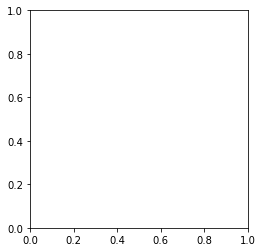

In [13]:
import matplotlib.pyplot as plt
pie_labels = ['Not Bankrupt', 'Bankrupt']
plt.pie([neg, pos], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribution of Bankruptcies')

plt.show()

### Resample the dataset

In [18]:
indices = bank_data[bank_data['status'] == 0].index
random_indices = np.random.choice(indices, size=neg-pos, replace=False)
bank_balanced = bank_data.drop(random_indices)

counts = bank_balanced['status'].value_counts()
print(counts)

0    5233
1    5233
Name: status, dtype: int64


In [19]:
numerical_only = bank_balanced.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik','fyear','status'], axis=1)
y = numerical_only['status']
X.head()

,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,inventory,total_current_liabilities,net_income,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,GOING_CONCERN
14,1116.900,2199.500,1581.400,564.300,113.400,142.600,256.000,453.600,632.900,402.100,72.900,616.700,297.900,2035.00,961.3080,1198.800,2035.00,1779.000,0.0
28,1077.400,1921.000,870.700,650.700,82.400,90.900,173.300,585.700,162.700,278.000,-41.900,-505.600,240.600,1456.40,705.6420,1006.800,1456.40,1283.100,1.0
39,12.686,21.401,19.334,0.023,1.686,-4.407,-2.721,14.946,6.950,16.483,-11.049,-21.447,4.282,34.28,5.0201,17.224,34.28,37.001,1.0
42,662.521,2390.008,505.498,1030.254,77.611,85.990,163.601,469.492,331.773,343.155,-37.914,-15.463,259.246,974.99,1172.2111,1498.392,974.99,811.389,1.0
50,4424.000,24374.000,15482.000,5689.000,1092.000,1156.000,2248.000,2248.000,708.000,5864.000,985.000,5716.000,1134.000,17730.00,9932.4150,17516.000,17730.00,15482.000,0.0


In [20]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)


Train set shapes: (7368, 19) (7368,)
Validation set shapes: (1842, 19) (1842,)
Test set shapes: (1256, 19) (1256,)


In [21]:
y_train.count()

7368

In [22]:
y_test.value_counts()

1    649
0    607
Name: status, dtype: int64

In [23]:
y_hot_test = tf.one_hot(y_test, depth=2)
y_hot_val = tf.one_hot(y_val, depth=2)
y_hot_train = tf.one_hot(y_train, depth=2)

In [ ]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

# # Split the data into train and test sets (80% train, 20% test)
# train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.15, random_state=42)

# # Further split the train data into train and validation sets (80% train, 20% validation)
# train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.17, random_state=42)

# # Perform oversampling on the train data
# # smote = SMOTE()

In [ ]:
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data, train_labels)

In [ ]:
val_data_resampled, val_labels_resampled = smote.fit_resample(val_data, val_labels)

In [282]:
input_shape = X.shape[1:]
print("Input Shape:", input_shape)

Input Shape: (19,)


In [ ]:
# y_hot_train = tf.one_hot(train_labels_resampled, 2)
# y_hot_val = tf.one_hot(val_labels_resampled, 2)
# y_hot_test = tf.one_hot(test_labels, 2)

## Evaluate the data distribution

In [506]:
import pandas as pd
import numpy as np

# Select the columns of interest
columns_of_interest = ['current_assets', 'cost_of_goods_sold', 'depreciation_and_amortization', 'ebitda',
                       'inventory', 'net_income', 'total_receivables', 'market_value', 'net_sales',
                       'total_assets', 'total_long_term_debt', 'ebit', 'gross_profit', 'total_current_liabilities',
                       'retained_earnings', 'total_revenue', 'total_liabilities', 'total_operating_expenses',
                       'GOING_CONCERN']

# Create an empty dataframe to store results
results_df = pd.DataFrame(columns=['Column', 'Mean', 'Variance', 'Range'])

# Calculate statistics for each column
for column in columns_of_interest:
    data = og_data[column]

    # Calculate mean, variance, and range
    mean = np.mean(data)
    variance = np.var(data)
    data_range = np.ptp(data)

    # Add row to the results dataframe
    results_df = results_df.append({'Column': column, 'Mean': mean, 'Variance': variance, 'Range': data_range},
                                   ignore_index=True)

# Display the results table
print(results_df)


                           Column         Mean      Variance         Range
0                  current_assets   877.446684  1.536613e+07  1.696698e+05
1              cost_of_goods_sold  1589.191097  7.940366e+07  3.749896e+05
2   depreciation_and_amortization   120.849169  4.240030e+05  2.843000e+04
3                          ebitda   375.343378  4.030445e+06  1.036430e+05
4                       inventory   200.928207  1.120234e+06  6.256700e+04
5                      net_income   128.682836  1.594337e+06  2.035170e+05
6               total_receivables   285.885926  1.777024e+06  6.581201e+04
7                    market_value  3402.912544  3.376191e+08  1.073391e+06
8                       net_sales  2356.044158  1.421817e+08  5.136940e+05
9                    total_assets  2858.946637  1.663861e+08  5.318640e+05
10           total_long_term_debt   720.747355  1.048586e+07  1.662500e+05
11                           ebit   254.494076  2.223949e+06  9.714300e+04
12                   gros

#### Preform one_hot encode to make binary values categorical

In [ ]:
y_hot = tf.one_hot(y, 2)

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

In [283]:
import os

def create_callbacks(checkpoint_dir, checkpoint_freq, checkpoint_period):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'ckpt_{epoch}'),
        save_freq=checkpoint_freq,
        period=checkpoint_period,
        # save_best_only=True
    )
    return [checkpoint_callback]

In [ ]:
def binary_classification(input_shape=(19,)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# # from tensorflow.keras import initializers
# # Define and compile the model

# def model_thing():
#   model = tf.keras.Sequential([
#     tf.keras.layers.Normalization(input_shape=input_shape),
#       tf.keras.layers.Dense(24, activation='relu', input_shape=input_shape),
#                             #bias_initializer=initializers.Constant(initial_bias)),
#       tf.keras.layers.Dense(12, activation='relu'),
#       tf.keras.layers.Dropout(0.2),
#       tf.keras.layers.Dense(2, activation='softmax')
#   ])

#   model.compile(loss='binary_crossentropy',
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, weight_decay=0.001),
#                 metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#   return model

# # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)


In [ ]:
callbacks = [
    #create_callbacks('model_checkpoints/model_going_all_data/', 'epoch', 10)
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
]
    # create_callbacks('model_checkpoints/model_going/', 10, 10)
    # tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoints/model_going/', 'epoch', 10, save_best_only=True)

# retrained model on full dataset
theMod = binary_classification()
theMod.fit(
    X_train,
    y_hot_train, 
    epochs=300, 
    batch_size=24, 
    validation_data=(X_val, y_hot_val),
    callbacks=callbacks
    )

# results = theMod.evaluate(train_data, y_hot_train, batch_size=24, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

In [ ]:
plot_history(theMod.history)

In [24]:
final_model = tf.keras.models.load_model('model_checkpoints/final_bankruptcy_model')

In [25]:
final_model.evaluate(X_test, y_hot_test, batch_size=24, verbose=0)

[9.411574363708496, 0.5843949317932129]

In [26]:
going_all_data = tf.keras.models.load_model('model_checkpoints/model_going_all_data/ckpt_300')
going_all_data.evaluate(X_test, y_hot_test, batch_size=32, verbose=0)

[7.795661449432373, 0.5851910710334778]

In [27]:
bonkrupt_predictions = going_all_data.predict(X_test)

40/40 [==============================] - 0s 1ms/step


In [ ]:
np.savetxt("prediction_csv/bankruptcy_predictions.csv", bonkrupt_predictions, delimiter=",")

In [28]:
bonkrupt_predictions_round = np.argmax(bonkrupt_predictions, axis=-1)

In [ ]:
np.savetxt("prediction_csv/bankruptcy_predictions_binary.csv", bonkrupt_predictions_round, delimiter=",")

In [29]:
precision = precision_score(y_test, bonkrupt_predictions_round)
recall = recall_score(y_test, bonkrupt_predictions_round)
f1_4 = f1_score(y_test, bonkrupt_predictions_round)

print( "precision: ", precision)
print( "recall: ", recall)
print("f1 score: ", f1_4)

precision:  0.5903954802259888
recall:  0.6440677966101694
f1 score:  0.6160648489314664


In [288]:
bp_train = going_all_data.predict(X_train)

231/231 [==============================] - 0s 2ms/step


In [289]:
bp_train_round = np.argmax(bp_train, axis=-1)

[[1960 1726]
 [1411 2271]]


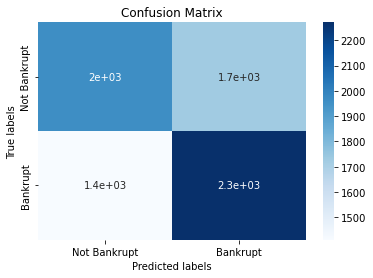

In [290]:
conf_mat1 = confusion_matrix(y_train, bp_train_round)
print(conf_mat1)
plot_cm(conf_mat1)

58/58 [==============================] - 0s 1ms/step
[[510 402]
 [363 567]]


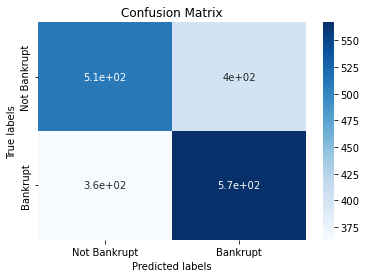

In [291]:
bp_val = going_all_data.predict(X_val)
bp_val_round = np.argmax(bp_val, axis=-1)
conf_mat2 = confusion_matrix(y_val, bp_val_round)
print(conf_mat2)
plot_cm(conf_mat2)

In [30]:
# display confusion matrix

def plot_cm(cm):
    # Define class labels
    class_labels = ["Not Bankrupt", "Bankrupt"]

    # Create heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")

    # Show plot
    plt.show()

[[317 318]
 [238 383]]


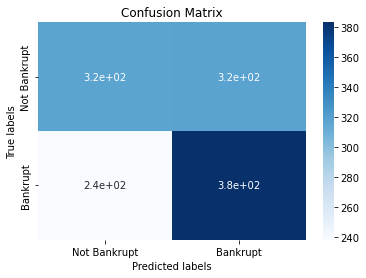

In [293]:
conf_mat = confusion_matrix(y_test, bonkrupt_predictions_round)
print(conf_mat)
plot_cm(conf_mat)

# Import Model 

In [6]:
import pandas as pd
# import file
og_data = pd.read_csv('fin_merged_data.csv')
numerical_only = og_data.select_dtypes(include=['float64','int64'])
labels = numerical_only['status']
data = numerical_only.drop(['cik','fyear','status'], axis=1)

In [581]:
neg1, pos1 = labels.to_numpy().tolist().count(0), labels.to_numpy().tolist().count(1)

In [564]:
# range of years
import pandas as pd

# Specify the column name
column_name = 'fyear'

# Get the range of values in the column
print(og_data[column_name].max(), og_data[column_name].min())


2018.0 1999.0


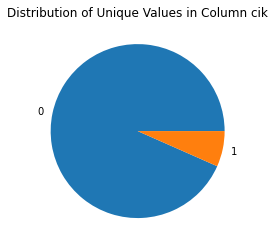

In [7]:
import pandas as pd
# Specify the column name
column_name = 'cik'

# Get the count of unique values in the column
unique_values_count = og_data[column_name].nunique()

# Print the count of unique values
print('Number of unique values in column', column_name, ':', unique_values_count)


Number of unique values in column cik : 8971


In [31]:
import numpy as np
# Merging the label array and feature array
fresh_data = pd.concat([X_train, y_train], axis=1)

# Print the merged array
fresh_labels = fresh_data['status']

fresh_data = fresh_data.drop(['status'], axis=1)


## Correlation Matrix between going-concern and bankruptcy outcome
Correlation between 2 binary values

                 status  GOING_CONCERN
status         1.000000       0.072219
GOING_CONCERN  0.072219       1.000000


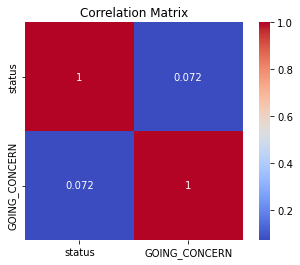

In [338]:
import pandas as pd
import seaborn as sns

bin_vals = og_data[['status', 'GOING_CONCERN']]

# Calculate the correlation matrix
correlation_matrix = bin_vals.corr()
print(correlation_matrix)
# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [346]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr

def calculate_point_biserial_correlation(data, binary_variable, continuous_variables):
    coefficients = []
    
    for continuous_var in continuous_variables:
        coefficient, _ = pointbiserialr(data[binary_variable], data[continuous_var])
        coefficients.append(coefficient)
    
    return coefficients

# Example usage
binary_variable = 'status'
continuous_variables = ['current_assets', 'cost_of_goods_sold', 'depreciation_and_amortization',
                        'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value',
                        'net_sales', 'total_assets', 'total_long_term_debt', 'ebit', 'gross_profit',
                        'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities',
                        'total_operating_expenses','GOING_CONCERN']

# Create a DataFrame with the columns and pass it to the function
doota = numerical_only.drop(['fyear', 'cik'], axis=1)
doota = pd.DataFrame(doota, columns=[binary_variable] + continuous_variables)

correlation_coefficients = calculate_point_biserial_correlation(doota, binary_variable, continuous_variables)
for var, coefficient in zip(continuous_variables, correlation_coefficients):
    print(f"Point-Biserial Correlation Coefficient between '{var}' and '{binary_variable}': {coefficient}")


Point-Biserial Correlation Coefficient between 'current_assets' and 'status': -0.03252390042432621
Point-Biserial Correlation Coefficient between 'cost_of_goods_sold' and 'status': -0.02195166917511089
Point-Biserial Correlation Coefficient between 'depreciation_and_amortization' and 'status': -0.014368751585057054
Point-Biserial Correlation Coefficient between 'ebitda' and 'status': -0.0314399609106158
Point-Biserial Correlation Coefficient between 'inventory' and 'status': -0.024496314211462134
Point-Biserial Correlation Coefficient between 'net_income' and 'status': -0.03726850091864551
Point-Biserial Correlation Coefficient between 'total_receivables' and 'status': -0.030667232608204014
Point-Biserial Correlation Coefficient between 'market_value' and 'status': -0.03690198277555557
Point-Biserial Correlation Coefficient between 'net_sales' and 'status': -0.026224513350650076
Point-Biserial Correlation Coefficient between 'total_assets' and 'status': -0.024721946940589073
Point-Bise

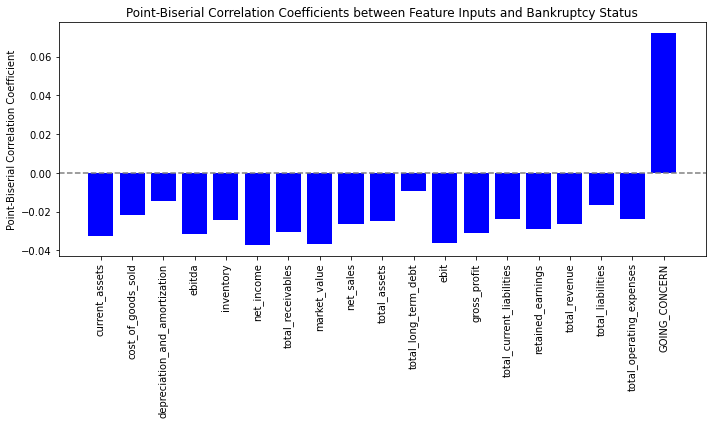

In [349]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(continuous_variables, correlation_coefficients, color='blue')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Point-Biserial Correlation Coefficient')
plt.title('Point-Biserial Correlation Coefficients between Feature Inputs and Bankruptcy Status')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## "What-if" experiments
Run what-if experiments on by changing the 'GOING_CONCERN' values for different companies.
 - Companies that went bankrupt (status = 1) and were predicted by going-concern reports to go bankrupt (GOING_CONCERN = 1)
    - Changed going-concern value to 0
 - Companies that did not go bankrupt (status = 0) and were not predicted to go bankrupt by going-concern reports (GOING_CONCERN = 0)
    - Changed going-concern value to 1

In [32]:
def calculate_metrics(pred, actual):
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    f1 = f1_score(actual, pred)
    
    #print all metrics together
    print('Precision: {}\nRecall: {}\nF1 Score: {}'.format(precision, recall, f1))


### Bankrupt and Going-Concern: negative to positive (1 -> 0)
Going-concern predicted bankrupt and company bankrupt

In [295]:
# Select rows where 'status' = 1 and 'GOING_CONCERN' = 1
neg_bankrupt = data[(labels == 1) & (data['GOING_CONCERN'] == 1)]

# change all values in 'GOING_CONCERN' to 0
neg_bankrupt['GOING_CONCERN'] = 0

/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_3042/3596576349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_bankrupt['GOING_CONCERN'] = 0


In [296]:
# make predictions and save probabilities and binary results to csv
neg_bkrupt_pred = going_all_data.predict(neg_bankrupt)
np.savetxt("prediction_csv/neg_bankrupt_probs.csv", neg_bkrupt_pred, delimiter=",")
neg_bkrupt_round = np.argmax(neg_bkrupt_pred, axis=-1)
np.savetxt("prediction_csv/neg_bankrupt_binary.csv", neg_bkrupt_round, delimiter=",")

108/108 [==============================] - 0s 2ms/step


In [297]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(neg_bkrupt_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 991 | Bankrupt: 2452


### Bankrupt and Going-Concern: positive to negative (0 to 1)
Going-concern did not predict bankrupt but went bankrupt

In [298]:
# Select rows where 'status' = 1 and 'GOING_CONCERN' = 0
pos_bankrupt = data[(labels == 1) & (data['GOING_CONCERN'] == 0)]

# change all values in 'GOING_CONCERN' to 1
pos_bankrupt['GOING_CONCERN'] = 1

/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_3042/620989802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_bankrupt['GOING_CONCERN'] = 1


In [299]:
# make predictions and save probabilities and binary results to csv
pos_bkrupt_pred = going_all_data.predict(pos_bankrupt)
np.savetxt("prediction_csv/pos_bankrupt_probs.csv", pos_bkrupt_pred, delimiter=",")
pos_bkrupt_round = np.argmax(pos_bkrupt_pred, axis=-1)
np.savetxt("prediction_csv/pos_bankrupt_binary.csv", pos_bkrupt_round, delimiter=",")

56/56 [==============================] - 0s 2ms/step


In [300]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(pos_bkrupt_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 1028 | Bankrupt: 762


### Not Bankrupt and Going-Concern negative to positive (1 to 0)
Going-concern predicted bankruptcy but company did not go bankrupt

In [301]:
# Select rows where 'status' = 0 and 'GOING_CONCERN' = 1
neg_not_bankrupt = data[(labels == 0) & (data['GOING_CONCERN'] == 1)]

# change all values in 'GOING_CONCERN' to 0
neg_not_bankrupt['GOING_CONCERN'] = 0

/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_3042/3911902336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_not_bankrupt['GOING_CONCERN'] = 0


In [302]:
# make predictions and save probabilities and binary results to csv
neg_not_bankrupt_pred = going_all_data.predict(neg_not_bankrupt)
np.savetxt("prediction_csv/neg_not_bankrupt_probs.csv", neg_not_bankrupt_pred, delimiter=",")
neg_not_bankrupt_round = np.argmax(pos_bkrupt_pred, axis=-1)
np.savetxt("prediction_csv/neg_not_bankrupt_binary.csv", neg_not_bankrupt_round, delimiter=",")

1184/1184 [==============================] - 2s 2ms/step


In [303]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(neg_not_bankrupt_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 1028 | Bankrupt: 762


### Not Bankrupt and Going-Concern positive to negative (0 to 1)
Going-concern did not predict bankruptcy and company did not go bankrupt

In [306]:
# Select rows where 'status' = 0 and 'GOING_CONCERN' = 1
pos_not_bankrupt = data[(labels == 0) & (data['GOING_CONCERN'] == 0)]

# change all values in 'GOING_CONCERN' to 0
pos_not_bankrupt['GOING_CONCERN'] = 1

/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_3042/1339708479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_not_bankrupt['GOING_CONCERN'] = 1


In [307]:
# make predictions and save probabilities and binary results to csv
pos_not_bankrupt_pred = going_all_data.predict(pos_not_bankrupt)
np.savetxt("prediction_csv/pos_not_bankrupt_probs.csv", pos_not_bankrupt_pred, delimiter=",")
pos_not_bankrupt_round = np.argmax(pos_not_bankrupt_pred, axis=-1)
np.savetxt("prediction_csv/pos_not_bankrupt_binary.csv", pos_not_bankrupt_round, delimiter=",")

1124/1124 [==============================] - 2s 2ms/step


In [308]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(pos_not_bankrupt_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 26599 | Bankrupt: 9363


### Plotting functions

In [524]:
# import matplotlib.pyplot as plt
# import numpy as np

# def thanos_plot (predicted, actual, species):
#     # convert to precentages
#     total_values = len(actual)
#     neg_pred, pos_pred = np.bincount(predicted)
#     neg_actual, pos_actual = np.bincount(actual)
    
#     neg_pred = (neg_pred / total_values) * 100
#     pos_pred = (pos_pred / total_values) * 100
#     neg_actual = (neg_actual / total_values) * 100
#     pos_actual = (pos_actual / total_values) * 100
    
#     weight_counts = {
#         "Bankrupt": np.array([neg_pred, neg_actual]),
#         "Non-Bankrupt": np.array([pos_pred, pos_actual]),
#     }
#     width = 0.5

#     fig, ax = plt.subplots()
#     bottom = np.zeros(2)

#     for boolean, weight_count in weight_counts.items():
#         p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
#         bottom += weight_count

#     ax.legend(loc="lower right")
    
#     ax.yaxis.set_major_formatter(mticker.PercentFormatter())

#     # Calculate the percentage difference between the two categories
#     percentage_difference = ((weight_counts["Bankrupt"][1] - weight_counts["Bankrupt"][0]) / weight_counts["Bankrupt"][0]) * 100

#     text = f"Percentage Difference: {percentage_difference:.2f}%"
#     print(text)

#     plt.show()

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

def thanos_plot (predicted, actual, species):
    # convert to precentages
    total_values = len(actual)
    neg_pred, pos_pred = np.bincount(predicted)
    neg_actual, pos_actual = np.bincount(actual)
    
    neg_pred = (neg_pred / total_values) * 100
    pos_pred = (pos_pred / total_values) * 100
    neg_actual = (neg_actual / total_values) * 100
    pos_actual = (pos_actual / total_values) * 100
    
    weight_counts = {
        "Bankrupt": np.array([neg_pred, neg_actual]),
        "Non-Bankrupt": np.array([pos_pred, pos_actual]),
    }
    width = 0.5

    fig, ax = plt.subplots()
    bottom = np.zeros(2)
    for boolean, weight_count, color in zip(weight_counts.keys(), weight_counts.values(), colors):
        p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom, color=color)
        bottom += weight_count

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="lower right")
    
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    # Calculate the percentage difference between the two categories
    percentage_difference = ((weight_counts["Bankrupt"][1] - weight_counts["Bankrupt"][0]) / weight_counts["Bankrupt"][0]) * 100

    text = f"Percentage Difference: {percentage_difference:.2f}%"
    print(text)
    print("TP: ", weight_counts["Bankrupt"][0])
    print("FP: ", weight_counts["Bankrupt"][1])
    
    print("TN: ", weight_counts["Non-Bankrupt"][0])
    print("FN: ", weight_counts["Non-Bankrupt"][1])

    plt.show()

In [483]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_results (predicted, actual, title):
    x_labels = ['Not Bankrupt', 'Bankrupt']
    # convert to precentages
    total_values = len(actual)
    neg_pred, pos_pred = np.bincount(predicted)
    neg_actual, pos_actual = np.bincount(actual)
    
    neg_pred = (neg_pred / total_values) * 100
    pos_pred = (pos_pred / total_values) * 100
    neg_actual = (neg_actual / total_values) * 100
    pos_actual = (pos_actual / total_values) * 100
    
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    
    offset = width * multiplier
    rects = ax.bar(x + offset, pos_actual, width, label='Not Bankrupt Actual')
    ax.bar_label(rects, padding=3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Precentage')
    ax.set_title(title)
    ax.set_xticks(x + width, x_labels)
    ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 100)

    plt.show()

In [39]:
def plot_going_results2(predicted, actual, title):
    categories = ['Pred\nBankrupt', 'Actual\nBankrupt', 'Pred Not\nBankrupt', 'Actual Not\nBankrupt']
    pred_neg, pred_pos = np.bincount(predicted)
    actual_neg, actual_pos = np.bincount(actual)

    # Set positions of bars on x-axis
    x = np.arange(len(categories))

    # Plot bars
    plt.bar(x, [pred_pos, actual_pos, pred_neg, actual_neg], label='Predicted')

    # Set labels and titles
    plt.ylabel("Number of Occurrences")
    plt.title(title)

    # Set x ticks
    plt.xticks(x, categories)

    # Add counts above the bars
    for i, count in enumerate([pred_pos, actual_pos, pred_neg, actual_neg]):
        plt.text(i, count + 5, str(count), ha='center', va='bottom')

    # Add a legend
    plt.legend()

    plt.show()

In [481]:
import matplotlib.pyplot as plt
import numpy as np

def plot_going_results(predicted, actual, title):
    categories = ['Bankrupt', 'Not Bankrupt']
    pred_neg, pred_pos = np.bincount(predicted)
    actual_neg, actual_pos = np.bincount(actual)
    
    # arrays will always be the same size
    total = len(predicted)
    
    # Calculate percentages
    pred_bankrupt_percentage = (pred_pos / total) * 100
    pred_not_percentage = (pred_neg / total) * 100
    actual_bankrupt_percentage = (actual_pos / total) * 100
    actual_not_percentage = (actual_neg / total) * 100
    
    # Set positions of bars on x-axis
    x = np.arange(len(categories))
    
    # Plotting the stacked bars with percentages
    plt.bar(x, [pred_bankrupt_percentage, pred_not_percentage], label='Predicted', color='blue')
    plt.bar(x, [actual_bankrupt_percentage, actual_not_percentage], bottom=[0, 0],
            label='Actual', color='green')

    # Set labels and title
    plt.ylabel('Percentage')
    plt.title(title)
    
    # Set x ticks
    plt.xticks(x, categories)
    
    # Set y-axis limits to show both bar charts
    plt.ylim(0, 100)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [509]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar(predicted, actual):
    categories = ['Positive', 'Negative']
    width = 0.5
    
    # Split predicted and actual into positive and negative
    pred_neg, pred_pos = np.bincount(predicted)
    actual_neg, actual_pos = np.bincount(actual)
    
    # Calculate percentages
    total = len(predicted)
    pred_pos_percentage = (pred_pos / total) * 100
    pred_neg_percentage = (pred_neg / total) * 100
    actual_pos_percentage = (actual_pos / total) * 100
    actual_neg_percentage = (actual_neg / total) * 100
    
    # Create the stacked bar plot
    fig, ax = plt.subplots()
    bottom = np.zeros(2)
    
    for i, category in enumerate(categories):
        p = ax.bar(category, [pred_pos_percentage, pred_neg_percentage][i], width, label='Predicted', bottom=bottom)
        bottom += [pred_pos_percentage, pred_neg_percentage][i]

    for i, category in enumerate(categories):
        p = ax.bar(category, [actual_pos_percentage, actual_neg_percentage][i], width, label='Actual', bottom=bottom)
        bottom += [actual_pos_percentage, actual_neg_percentage][i]
    
    # Set labels and title
    ax.set_ylabel('Percentage')
    ax.set_title('Predicted and Actual Values')
    
    # Add a legend
    ax.legend(loc='lower right')
    
    # Show the plot
    plt.show()

Percentage Difference: 14.29%
TP:  70
FN:  80
FP:  30
TN:  20


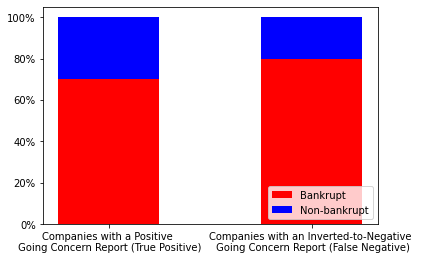

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

species = (
    "Companies with a Positive \n Going Concern Report (True Positive)",
    "Companies with an Inverted-to-Negative \n Going Concern Report (False Negative)",
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

colors = ['red', 'blue'] 

for boolean, weight_count, color in zip(weight_counts.keys(), weight_counts.values(), colors):
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom, color=color)
    bottom += weight_count

ax.legend(loc="lower right")


ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Calculate the percentage difference between the two categories
percentage_difference = ((weight_counts["Bankrupt"][1] - weight_counts["Bankrupt"][0]) / weight_counts["Bankrupt"][0]) * 100

text = f"Percentage Difference: {percentage_difference:.2f}%"
print(text)
print("TP: ", weight_counts["Bankrupt"][0])
print("FN: ", weight_counts["Bankrupt"][1])
print("FP: ", weight_counts["Non-bankrupt"][0])
print("TN: ", weight_counts["Non-bankrupt"][1])


plt.show()

### All companies that recieved a negative going-concern report regardless of 'status'
Change going-concern from negative to positive

In [33]:
# Select rows where 'GOING_CONCERN' = 1
neg_going = fresh_data[(fresh_data['GOING_CONCERN'] == 1)]
neg_going_status = fresh_labels[(fresh_data['GOING_CONCERN'] == 1)]
print(neg_going_status.value_counts())
# change all values in 'GOING_CONCERN' to 0
neg_going['GOING_CONCERN'] = 0
neg_going.head()

1    2398
0    1888
Name: status, dtype: int64


/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_12038/3593429150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_going['GOING_CONCERN'] = 0


,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,inventory,total_current_liabilities,net_income,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,GOING_CONCERN
77788,233.927,312.589,181.776,200.091,6.283,-127.668,-121.385,-121.385,15.334,23.454,-162.141,-479.472,7.600,60.391,204.8210,226.213,60.391,181.776,0
33926,16.655,31.440,80.706,12.028,0.478,2.498,2.976,8.835,3.526,10.392,-0.105,-41.699,9.395,89.541,10.0819,22.420,89.541,86.565,0
63180,0.595,4.415,0.273,1.612,0.365,-0.564,-0.199,0.196,0.000,0.019,-0.785,-10.753,0.034,0.469,35.5136,1.631,0.469,0.668,0
47119,111.901,240.531,40.235,24.643,13.523,12.647,26.170,113.913,40.484,30.989,-26.189,-18.492,34.032,154.148,772.1972,65.279,154.148,127.978,0
23961,56.114,116.455,264.460,63.517,1.625,10.491,12.116,57.564,0.000,25.212,-0.471,-74.946,50.357,322.024,24.5655,94.250,322.024,309.908,0


In [34]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(neg_going_status)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 1888 | Bankrupt: 2398


In [40]:
# make predictions and save probabilities and binary results to csv
neg_going_pred = going_all_data.predict(neg_going)
np.savetxt("prediction_csv/neg_going_probs2.csv", neg_going_pred, delimiter=",")
neg_going_round = np.argmax(neg_going_pred, axis=-1)
np.savetxt("prediction_csv/neg_going_binary2.csv", neg_going_round, delimiter=",")

134/134 [==============================] - 0s 1ms/step


In [41]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(neg_going_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 1403 | Bankrupt: 2883


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_going_results2(predicted, actual, title):
    categories = ['Bankrupt', 'Not Bankrupt']
    
    total_elements = predicted.size
    
    pred_neg, pred_pos = np.bincount(predicted)
    actual_neg, actual_pos = np.bincount(actual)
    
    # Calculate percentages
    pred_pos_percentage = (pred_pos / total_elements) * 100
    pred_neg_percentage = (pred_neg / total_elements) * 100
    actual_pos_percentage = (actual_pos / total_elements) * 100
    actual_neg_percentage = (actual_neg / total_elements) * 100
    
    print(pred_pos_percentage, pred_neg_percentage, actual_pos_percentage, actual_neg_percentage)
    
    # Set positions of bars on x-axis
    x = np.arange(len(categories))
    
    # Plotting the stacked bars with percentages
    plt.bar(x, [actual_pos_percentage, actual_neg_percentage], label='Predicted', color='blue')
    plt.bar(x, [pred_pos_percentage, pred_neg_percentage], bottom=[actual_pos_percentage, actual_neg_percentage],
            label='Actual', color='green')

    # Set labels and title
    plt.ylabel('Percentage')
    plt.title(title)
    
    # Set x ticks
    plt.xticks(x, categories)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()


Percentage Difference: -25.69%
TP:  44.05039664022399
FP:  32.73448436770882
TN:  55.94960335977601
FN:  67.26551563229118


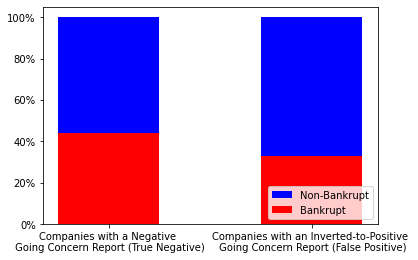

In [52]:
# 1 to 0
species_invert_pos = (
    "Companies with a Negative \n Going Concern Report (True Negative)",
    "Companies with an Inverted-to-Positive \n Going Concern Report (False Positive)"
)
thanos_plot(neg_going_round, neg_going_status, species_invert_pos)

precentages:  55.325914149443555 44.67408585055644 67.74926186690892 32.250738133091076


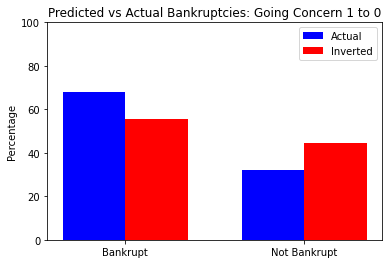

In [498]:
plot_going_results_stacked(neg_going_round, neg_going_status, 'Predicted vs Actual Bankruptcies: Going Concern 1 to 0')

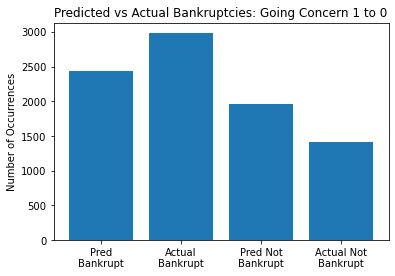

In [388]:
plot_going_results(neg_going_round, neg_going_status, 'Predicted vs Actual Bankruptcies: Going Concern 1 to 0')

### All companies that recieved a positive going-concern report regardless of 'status'
Change going-concern from positive to negative

In [54]:
# Select rows where 'GOING_CONCERN' = 0
pos_going = data[(data['GOING_CONCERN'] == 0)]
pos_going_status = labels[(data['GOING_CONCERN'] == 0)]
print(pos_going_status.value_counts())
# change all values in 'GOING_CONCERN' to 1
pos_going['GOING_CONCERN'] = 1
pos_going.head()

0    35962
1     1790
Name: status, dtype: int64


/var/folders/bz/vm79k19966x72r5s425vw7zm0000gp/T/ipykernel_12038/1560408523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_going['GOING_CONCERN'] = 1


,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,inventory,total_current_liabilities,net_income,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,GOING_CONCERN
0,511.267,740.998,833.107,180.447,18.373,70.658,89.031,191.226,336.018,163.816,35.163,201.026,128.348,1024.333,372.7519,401.483,1024.333,935.302,1
1,485.856,701.854,713.811,179.987,18.577,45.790,64.367,160.444,320.590,125.392,18.531,204.065,115.187,874.255,377.1180,361.642,874.255,809.888,1
2,436.656,710.199,526.477,217.699,22.496,4.711,27.207,112.244,286.588,150.464,-58.939,139.603,77.528,638.721,364.5928,399.964,638.721,611.514,1
3,396.412,686.621,496.747,164.658,27.172,3.573,30.745,109.590,259.954,203.575,-12.410,124.106,66.322,606.337,143.3295,391.633,606.337,575.592,1
4,432.204,709.292,523.302,248.666,26.680,20.811,47.491,128.656,247.245,131.261,3.504,131.884,104.661,651.958,308.9071,407.608,651.958,604.467,1


In [55]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(pos_going_status)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 35962 | Bankrupt: 1790


In [56]:
# make predictions and save probabilities and binary results to csv
pos_going_pred = going_all_data.predict(pos_going)
np.savetxt("prediction_csv/pos_going_probs.csv", pos_going_pred, delimiter=",")
pos_going_round = np.argmax(pos_going_pred, axis=-1)
np.savetxt("prediction_csv/pos_going_binary.csv", pos_going_round, delimiter=",")

1180/1180 [==============================] - 2s 1ms/step


In [57]:
# count occurrences of 0 and 1 in the array
neg, pos = np.bincount(pos_going_round)
print('Not bankrupt: {} | Bankrupt: {}'.format(neg, pos))

Not bankrupt: 27627 | Bankrupt: 10125


Percentage Difference: 465.64%
TP:  4.74147065056156
FP:  26.81977113795296
TN:  95.25852934943843
FN:  73.18022886204704


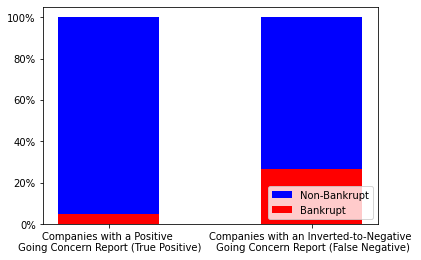

In [91]:
# 0 to 1
species_invert_neg = (
    "Companies with a Positive \n Going Concern Report (True Positive)",
    "Companies with an Inverted-to-Negative \n Going Concern Report (False Negative)"
)
thanos_plot(pos_going_round, pos_going_status,species_invert_neg)

precentages:  26.81977113795296 73.18022886204704 4.74147065056156 95.25852934943843


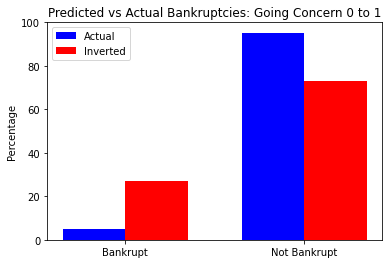

In [499]:
plot_going_results_stacked(pos_going_round, pos_going_status, 'Predicted vs Actual Bankruptcies: Going Concern 0 to 1')

### Monte Carlo Simulations

In [ ]:
# Load the model
BRUPTY = tf.keras.models.load_model('model_checkpoints/model_going/ckpt_300')

In [ ]:
feature_to_change = 'GOING_CONCERN'  # feature to be modified
range_of_values = [0, 0.3, 0.5, 0.7, 1]  # value higher to 1 means more negative going concern impact
num_iterations = 2  # number of iterations to run the model

In [ ]:
import random
import numpy as np

def bankrupt_monte_carlo(num_iterations, mod_val, data, feature_to_change):
    bankruptcy_probabilities = []
    for _ in range (num_iterations):
        # copy the original dataset
        modified_data = data.copy()
        # change the going_concern value to the modified value
        modified_data[feature_to_change] = mod_val
        # make predictions using the trained neural network model on the modified input data
        predictions = BRUPTY.predict(modified_data)
        # record the bankruptcy probability
        bankruptcy_probabilities.append(predictions[:, 1])
    bankruptcy_probabilities = np.array(bankruptcy_probabilities)
    return bankruptcy_probabilities

In [ ]:
neg_og_results = bankrupt_monte_carlo(3, 1, bankrupt_neg, feature_to_change)

In [ ]:
# monte carlo simulation for status = 1 and going_concern = 1
# going_concern changed to 0
to_pos_results = bankrupt_monte_carlo(3, 0, bankrupt_neg, feature_to_change)

In [ ]:
to_pos_results = to_pos_results.flatten()

In [ ]:
neg_og_results = neg_og_results.flatten()

In [ ]:
pos_og_results = bankrupt_monte_carlo(3, 0, bankrupt_pos, feature_to_change)

In [ ]:
to_neg_results = bankrupt_monte_carlo(3, 1, bankrupt_pos, feature_to_change)

In [ ]:
pos_og_results = pos_og_results.flatten()
to_neg_results = to_neg_results.flatten()

In [ ]:
import matplotlib.pyplot as plt

# Data
stuff = [neg_og_results, to_pos_results]

# Plotting
plt.figure(figsize=(8, 6))
plt.boxplot(stuff, labels=['Going-Concern 0', 'Going-Concern 1'])

plt.xlabel('Dataset')
plt.ylabel('Bankruptcy Probability')
plt.title('Distribution of Bankruptcies')

plt.grid(True)
plt.show()


In [ ]:
print(np.mean(neg_og_results))
print(np.mean(to_pos_results))

In [ ]:
# Apply the condition and convert values
arr = np.where(neg_og_results > 0.3, 1, 0)
arr2 = np.where(to_pos_results > 0.3, 1, 0)
count1 = np.count_nonzero(arr)
count2 = np.count_nonzero(arr2)

# Print the modified array
print(count1, count2)

In [ ]:
import matplotlib.pyplot as plt

# Data
stuff = [pos_og_results, to_neg_results]

# Plotting
plt.figure(figsize=(8, 6))
plt.boxplot(stuff, labels=['Going-Concern 0', 'Going-Concern 1'])

plt.xlabel('Dataset')
plt.ylabel('Bankruptcy Probability')
plt.title('Distribution of Bankruptcies')

plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot the results for each iteration
for i in range(bankruptcy_probabilities.shape[0]):
    iteration_values = bankruptcy_probabilities[i]
    plt.plot(range(len(iteration_values)), iteration_values, label=f'Iteration {i+1}')

plt.xlabel('Index')
plt.ylabel('Bankruptcy Probability')
plt.title('Impact of Modified Feature on Bankruptcy Probability')
plt.legend()
plt.show()


## Evaluate the entries with modified GOING_CONCERN values
GOING_CONCERN = 1 changed to 0
GOING_CONCERN = 0 changed to 1

In [ ]:
import tensorflow as tf
# Load the saved model
loaded_model = tf.keras.models.load_model('going_concern_impact_model')

In [ ]:
# neg to pos
neg_predictions = loaded_model.predict(bankrupt_neg)
# neg_predictions = np.argmax(neg_predictions, axis=-1)
neg_predictions_og = loaded_model.predict(bonk_neg)

# Print the predictions
print(neg_predictions)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the difference in probabilities between classes
diff_probs = (neg_predictions[:, 1] - neg_predictions_og[:, 1])

# Plot the difference in probabilities
plt.plot(diff_probs)
plt.xlabel('Index')
plt.ylabel('Difference in Probabilities')
plt.title('Difference in Probabilities between Predictions')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming predictions_before and predictions_after are your prediction arrays before and after changing an input parameter

# Calculate the difference in predictions
diff_predictions = neg_predictions - neg_predictions_og

# Create the box and whisker plot
plt.boxplot(diff_predictions)
plt.xlabel('Class')
plt.ylabel('Difference in Predictions')
plt.title('Shift in Predictions after Changing Going-Concern from 1 to 0')
plt.xticks(ticks=[1, 2], labels=['Not Bankrupt', 'Bankrupt'])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming prob_array1 and prob_array2 are your 2D arrays of probabilities for two different conditions

# Calculate the cumulative probabilities for each condition
cumulative_probs1 = np.cumsum(neg_predictions, axis=0)
cumulative_probs2 = np.cumsum(neg_predictions_og, axis=0)

# Create the area plot
x = np.arange(len(neg_predictions))  # Assuming the x-axis represents the indices

plt.fill_between(x, cumulative_probs1[:, 0], alpha=0.5, label='Condition 1, Class 0')
plt.fill_between(x, cumulative_probs1[:, 1], alpha=0.5, label='Condition 1, Class 1')
plt.fill_between(x, cumulative_probs2[:, 0], alpha=0.5, label='Condition 2, Class 0')
plt.fill_between(x, cumulative_probs2[:, 1], alpha=0.5, label='Condition 2, Class 1')

plt.xlabel('Index')
plt.ylabel('Cumulative Probability')
plt.title('Comparison of Cumulative Probabilities between Conditions')
plt.legend()
plt.show()


In [ ]:
# pos to neg
pos_predictions = loaded_model.predict(bankrupt_pos)
pos_predictions = np.argmax(pos_predictions, axis=-1)

In [ ]:
# Select rows where 'status' = 1 and 'GOING_CONCERN' = 0
neg2_predictions = loaded_model.predict(bankrupt_neg2)
neg2_predictions = np.argmax(neg2_predictions, axis=-1)

In [ ]:
# Select rows where 'status' = 0 and 'GOING_CONCERN' = 1
pos2_predictions = loaded_model.predict(bankrupt_pos2)
pos2_predictions = np.argmax(pos2_predictions, axis=-1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming arr1 and arr2 are your arrays of binary values
def plot_bar(arr1, arr2, labels, title):
    # Count the occurrence of 1's in each array
    count1 = np.count_nonzero(arr1 == 1)
    count2 = np.count_nonzero(arr2 == 1)

    # Create the bar graph
    labels = labels
    values = [count1, count2]
    print('Predicted Bankrupt Companies: ', count1,'\nActual Bankrupt Companies: ', count2)

    plt.bar(labels, values)
    plt.xlabel('Arrays')
    plt.ylabel('Bankrupt Companies')
    plt.title(title)
    plt.show()


In [ ]:
plot_bar(neg_predictions, bn_actual, ['Neg to Pos', 'Actual'], 'Bankrupt Companies: Going-Concern Neg to Pos vs Actual')

In [ ]:
plot_bar(pos_predictions, bp_actual, ['Pos to Neg', 'Actual'], 'Bankrupt Companies: Going-Concern Pos to Neg vs Actual')

In [ ]:
plot_bar(neg2_predictions, bn2_actual, ['Neg to Pos', 'Actual'], 'Bankrupt Companies: Going-Concern Neg to Pos vs Actual')

In [ ]:
plot_bar(pos2_predictions, bp2_actual, ['Pos to Neg', 'Actual'], 'Bankrupt Companies: Going-Concern Pos to Neg vs Actual')

In [ ]:
# load and continue training 
model_loaded = tf.keras.models.load_model('model_checkpoints/model_going/ckpt_300')
callbacks_cont = [
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
    create_callbacks('model_checkpoints/model_going/', 'epoch', 10)    # create_callbacks('model_checkpoints/model_going/', 10, 10)
]
# callbacks4_continue = create_callbacks('model_checkpoints/model_going/', 'epoch', 10)
history4_continue = model_loaded.fit(X_train, y_hot_train,
                    validation_data=(X_val, y_hot_val),
                    epochs=500,
                    batch_size=24,
                    callbacks=callbacks_cont,
                    initial_epoch=300
                    # class_weight=class_weight
                    )

In [ ]:
plot_history(history4_continue)

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
weighted_model = model_thing()

In [ ]:
weighted_history = weighted_model.fit(
    train_data,
    y_hot_train,
    batch_size=24,
    epochs=20,
    # callbacks=[early_stopping],
    validation_data=(val_data, y_hot_val),
    # The class weights go here
    class_weight=class_weight)

In [ ]:
# Fit the model with the resampled train data
model.fit(train_data, y_hot_train,
          epochs=20,
          batch_size=24,
          validation_data=(val_data, y_hot_val),
          #callbacks=[early_stopping]
        )

In [ ]:
results = model.evaluate(train_data, y_hot_train, batch_size=24, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, y_hot_test, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

### Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_data), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

## Split Data

Split data into training testing and validation.
Remove non-numerical values.

In [ ]:
from sklearn.model_selection import train_test_split

# split data into training (70%), validation (15%), and testing (15%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.15, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.82, test_size=0.18, random_state=42, shuffle=True)

print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_test.value_counts())

input_shape = (X.shape[1],)

## Define helper functions

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(24, 16))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')
    
    fig.tight_layout(pad=0.5)

    plt.show()

In [ ]:
# display confusion matrix

def plot_cm(cm):
    # Define class labels
    class_labels = ["Not Bankrupt", "Bankrupt"]

    # Create heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")

    # Show plot
    plt.show()

## Define model

In [ ]:
X_validate.describe()

In [ ]:
def binary_classification_model(input_shape=(20,)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(22, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax'),
        # tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
]

### Preform a 1 hot encoding on the binary data to create categories

In [ ]:
y_hot_train = tf.one_hot(y_train, 2)
y_hot_val = tf.one_hot(y_validate, 2)
y_hot_test = tf.one_hot(y_test, 2)

In [ ]:
model = binary_classification_model()
# callbacks4 = create_callbacks('model_checkpoints/model4/', 'epoch', 5)
history4 = model.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=400,
                    batch_size=24,
                    callbacks=callbacks,
                    # class_weight=class_weight
                    )

In [ ]:
plot_history(history4)

In [ ]:
model.summary()

In [ ]:
y_predict_probs = model.predict(X_test)
print(y_predict_probs)

# Convert probabilities to binary predictions using a threshold of 0.5
y_predict = np.round(y_predict_probs)
print(y_predict)

In [ ]:
# convert categorical to binary
binary_preds_1d = np.argmax(y_predict, axis=1)
print(binary_preds_1d)

precision = precision_score(y_test, binary_preds_1d)
recall = recall_score(y_test, binary_preds_1d)
f1_4 = f1_score(y_test, binary_preds_1d)

print( "precision: ", precision)
print( "recall: ", recall)
print("f1 score: ", f1_4)

In [ ]:
conf_mat = confusion_matrix(y_test, binary_preds_1d)
print(conf_mat)
plot_cm(conf_mat)